# Setup

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [33]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2, slope_threshold=0.5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None:
        return
    
    xsize = img.shape[1]
    ysize = img.shape[0]
    left_lane = []
    right_lane = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if ((y2-y1)/(x2-x1)) > slope_threshold:
                right_lane.append((x1, y1))
                right_lane.append((x2, y2))
            elif ((y2-y1)/(x2-x1)) < -slope_threshold:
                left_lane.append((x1, y1))
                left_lane.append((x2, y2))

    if len(left_lane) > 0:
        x,y = zip(*left_lane)
        m, b = np.polyfit(x,y, 1)
        cv2.line(img,
                 (int(solve_linear_eq(ysize, m, b)), ysize),
                 (int(solve_linear_eq(min(y), m, b)), int(min(y))),
                 color,
                 thickness)
    
    if len(right_lane) > 0:
        x,y = zip(*right_lane)
        m, b = np.polyfit(x,y, 1)
        cv2.line(img,
                 (int(solve_linear_eq(ysize, m, b)), ysize),
                 (int(solve_linear_eq(min(y), m, b)), int(min(y))),
                 color,
                 thickness)


def solve_linear_eq(x, m, b):
    return x*m+b

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    return cv2.LUT(image, table)

## Image Tests

In [32]:
import os
os.listdir("test_images/")

['extra2.jpg',
 'solidYellowCurve2.jpg',
 'extra1.jpg',
 'solidWhiteCurve.jpg',
 'extra.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'extra3.jpg',
 'solidWhiteRight.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [21]:
def process_image(img):
    img_gamma = adjust_gamma(img, 0.1)   
    img_gray = grayscale(img_gamma)
    img_blur = gaussian_blur(img_gray, 3)
    img_edge = canny(img_blur, 50, 150)
    
    imshape = image.shape
    top_width = 100
    top_offset = 350
    vertices = np.array([[(0,imshape[0]),
                          (imshape[1]/2-top_width, top_offset),
                          (imshape[1]/2+top_width, top_offset),
                          (imshape[1],imshape[0])]],
                        dtype=np.int32)
    img_region_masked = region_of_interest(img_edge, vertices)
  
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 20
    max_line_gap = 200
    img_hough = hough_lines(img_region_masked, rho, theta, threshold, min_line_length, max_line_gap)

    
    # Run Hough on edge detected image
    line_image = np.copy(image)*0
    lines = cv2.HoughLinesP(img_hough, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    result = np.copy(img)
    draw_lines(result, lines, thickness=5, slope_threshold=1)
    return result

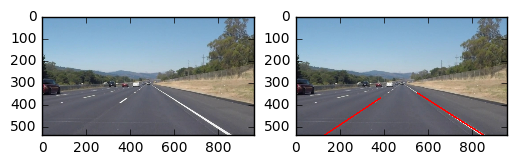

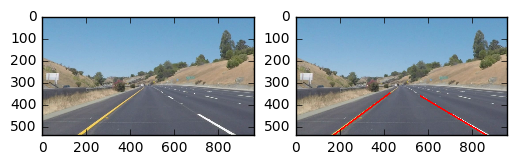

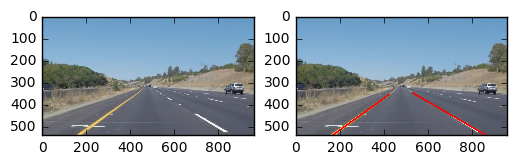

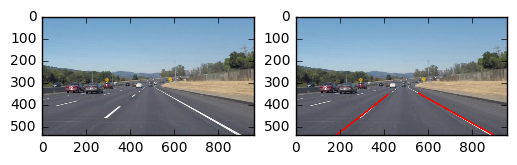

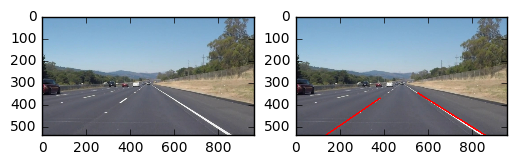

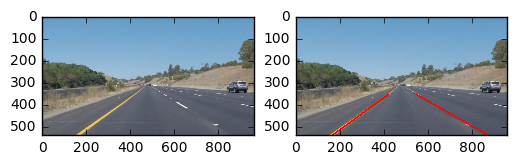

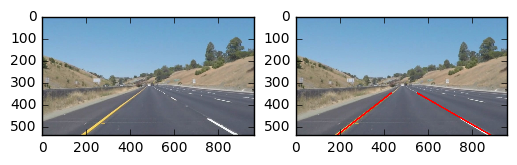

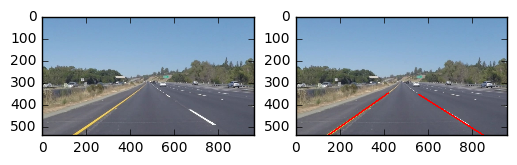

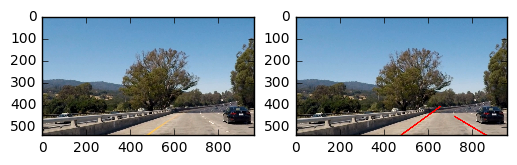

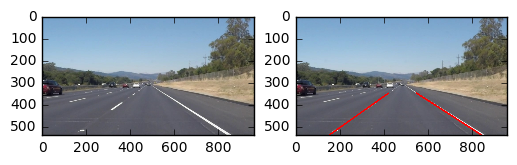

In [23]:
for img_path in os.listdir("test_images/"):

    image = mpimg.imread('test_images/' + img_path)
    processed = process_image(image)

    fig = plt.figure()
    ax1=fig.add_subplot(1,2,1)
    plt.imshow(image)
    ax1=fig.add_subplot(1,2,2)
    plt.imshow(processed)

## Test on Videos

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:11<00:00, 19.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 27.8 s, sys: 916 ms, total: 28.7 s
Wall time: 12.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [27]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:39<00:00, 17.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 42s, sys: 2.96 s, total: 1min 45s
Wall time: 40.4 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Test Challenge

In [29]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:25<00:00,  9.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 3s, sys: 2.14 s, total: 1min 6s
Wall time: 26.9 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Reflections




Even for the simple videos it's quite hard to find suitable parameters for the different filters. Finding a combination which actually kind of works involved a lot trial and error. 


One adjustment which seems to help is adding a threshold for the slope when drawing the lines, to prevent them to become vertical. To compensate the low contrast in the challenge video, I use a gamma reduction which works to some extend. 


Lower contrast than in the challenge video through different lighting conditions will likely cause the pipeline to fail. It already has a hard time keeping up the line in the brighter part of the video.


To improve the pipeline even further an exploration of other filters in the openCV framework would be a good starting point. I was also thinking about a machine learning approach using grid search leveraging sklearns pipeline constructs. For that some hand labeled images would be necessary.